In [311]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle
import diagnostic_plots
import datetime


import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
from copy import deepcopy

%matplotlib inline

In [312]:
with open('./data/processed/reduced_df2.pkl', 'rb') as picklefile:
    reduced_df2 = pickle.load(picklefile)

In [378]:
y = reduced_df2['price']
X = reduced_df2.drop(('price'), axis = 1, inplace = False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666)

In [380]:
X_train.head()

,images,age,city,highway,transmission,drive,engine,cylinder,horsepower,torque,...,make[T.Mitsubishi],make[T.Nissan],make[T.Pontiac],make[T.Porsche],make[T.Scion],make[T.Smart],make[T.Subaru],make[T.Toyota],make[T.Volkswagen],make[T.Volvo]
stock_id,,,,,,,,,,,,,,,,,,,,,
16057160,20,5,24,34,0,0,1.8,4,170,184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16057266,20,4,26,34,0,0,1.4,4,138,148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15867037,21,2,25,32,0,0,2.0,4,189,207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16211748,0,2,17,24,0,0,3.0,6,425,406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16062084,20,5,N/A,N/A,0,0,2.4,4,173,166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [382]:
y_train.head()

stock_id
16057160    11998.0
16057266    14998.0
15867037    22599.0
16211748    59998.0
16062084    12599.0
Name: price, dtype: float64

## Deal with the missing data first

In [383]:
def imput_training_avg(df, col, navalues):
    
    non_na = df    
    df[col] = df[col].astype(str)
    
    for navalue in navalues:
        non_na = non_na.loc[non_na[col]!= navalue]
    
    cal_mean = np.mean(non_na[col].astype(float))
    
    for navalue in navalues:
        df.loc[df[col] == navalue, col] = cal_mean

    return df[col].astype(float), cal_mean

In [384]:
def impute_training_avg(df, training_mean_dict, navalues):
    for col in training_mean_dict.keys():
        for navalue in navalues:
            df.loc[df[col] == navalue, col] = training_mean_dict[col]
        
        df.loc[:,col] = df[col].astype(float)
    return df

In [385]:
col_to_clean = ['city', 'highway', 'engine', 'cylinder', 'horsepower', 'torque']

training_mean_dict = {}
for col in col_to_clean:
    X_train.loc[:,col], cal_mean = imput_training_avg(X_train, col, ['N/A', '0'])
    training_mean_dict[col] = cal_mean

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [387]:
X_test = impute_training_avg(X_test, training_mean_dict, ['N/A', '0'])

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [388]:
X_train_num = deepcopy(X_train)
X_test_num = deepcopy(X_test)

In [476]:
X_train_num.describe()

,images,age,city,highway,transmission,drive,engine,cylinder,horsepower,torque,...,make[T.Mitsubishi],make[T.Nissan],make[T.Pontiac],make[T.Porsche],make[T.Scion],make[T.Smart],make[T.Subaru],make[T.Toyota],make[T.Volkswagen],make[T.Volvo]
count,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,...,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000
mean,19.693928,4.643742,23.676431,31.466045,0.048327,0.197646,2.748498,4.923947,227.042133,228.353175,...,0.003098,0.079926,0.000620,0.005576,0.003717,0.003717,0.017968,0.045849,0.052664,0.004337
std,5.884547,2.205802,10.384211,8.489948,0.214523,0.398347,1.095447,1.295660,77.806631,89.795191,...,0.055590,0.271262,0.024891,0.074489,0.060877,0.060877,0.132875,0.209222,0.223431,0.065734
min,0.000000,1.000000,12.000000,16.000000,0.000000,0.000000,0.060000,2.000000,70.000000,68.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,3.000000,19.000000,27.000000,0.000000,0.000000,2.000000,4.000000,172.000000,172.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21.000000,4.000000,23.000000,31.466045,0.000000,0.000000,2.400000,4.000000,208.000000,228.353175,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22.000000,6.000000,25.000000,35.000000,0.000000,0.000000,3.500000,6.000000,285.000000,264.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,29.000000,12.000000,128.000000,109.000000,1.000000,1.000000,6.700000,8.000000,550.000000,925.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Basic EDA

In [320]:
df_num_train = pd.concat((y_train, X_train_num), axis=1)

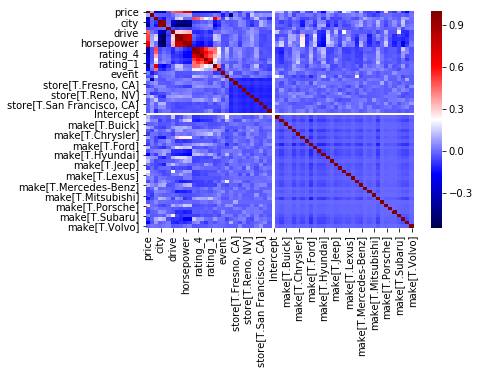

In [321]:
# Check correlations
sns.heatmap(df_num_train.corr(), cmap="seismic");

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


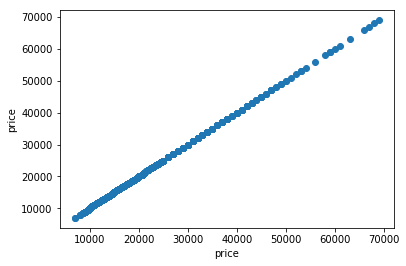

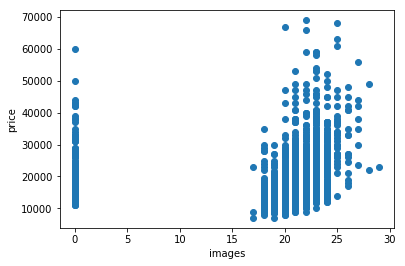

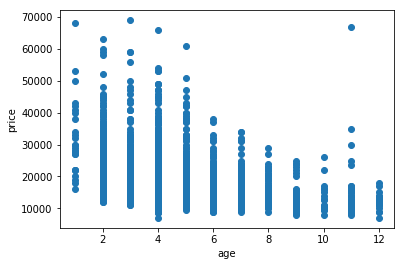

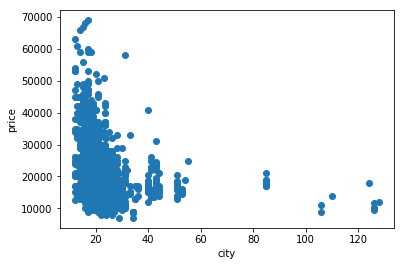

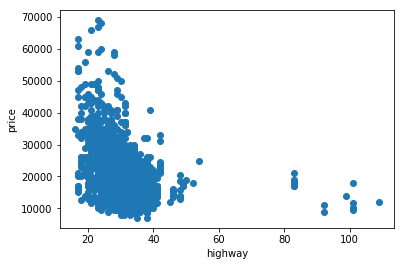

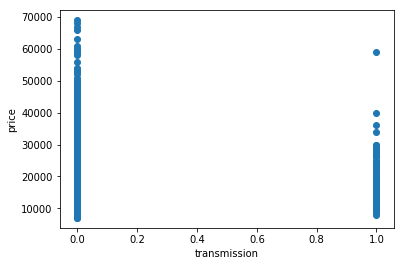

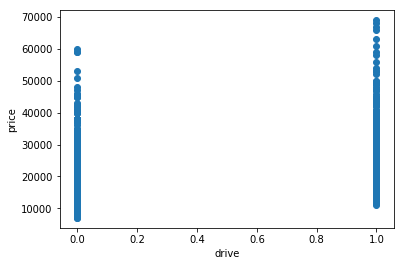

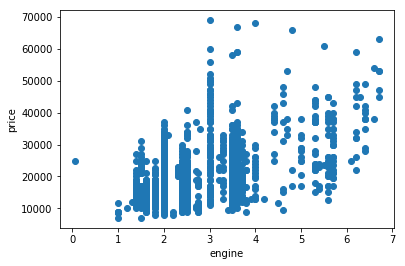

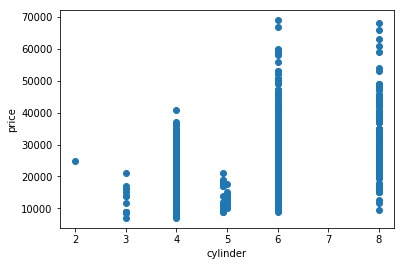

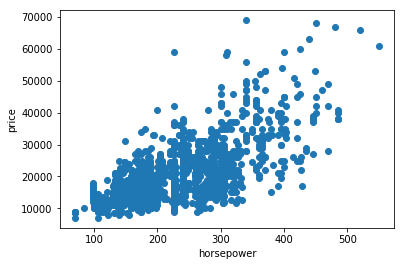

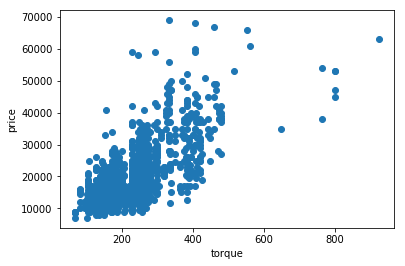

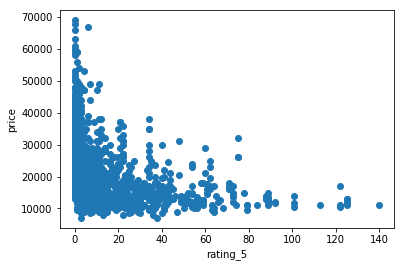

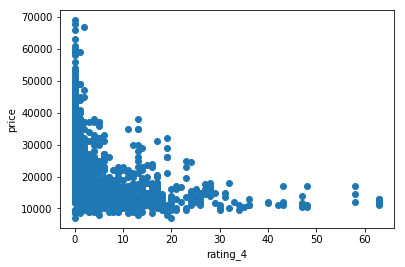

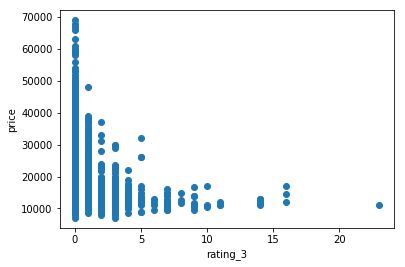

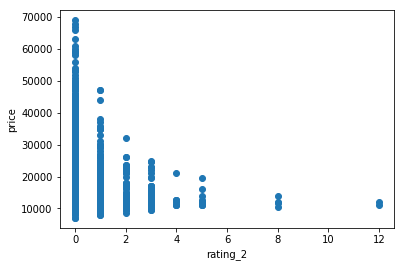

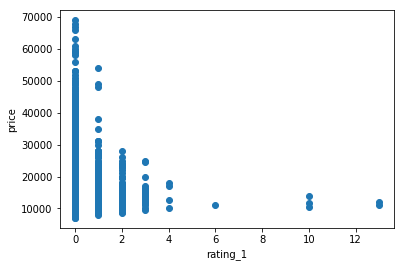

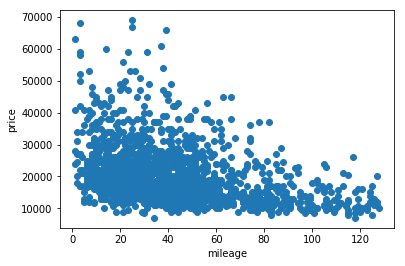

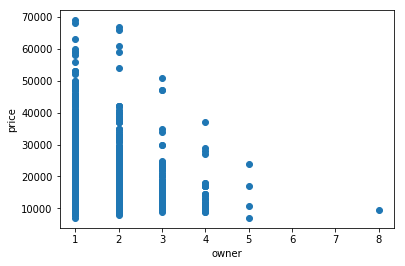

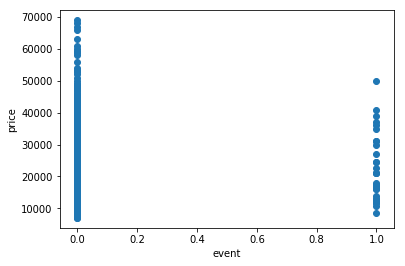

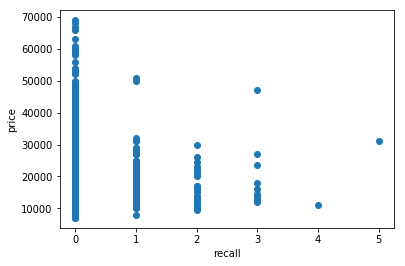

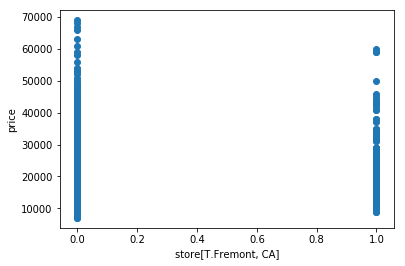

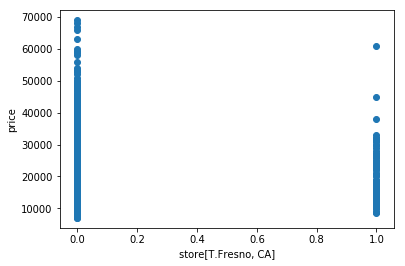

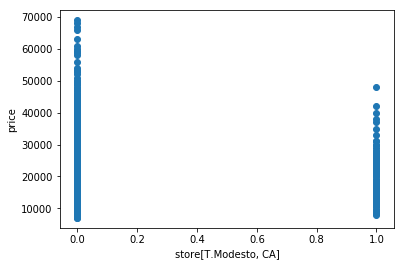

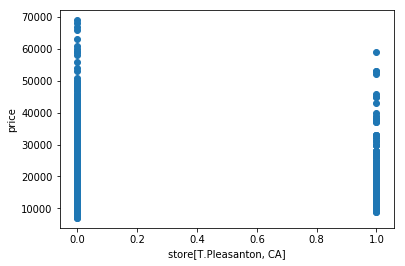

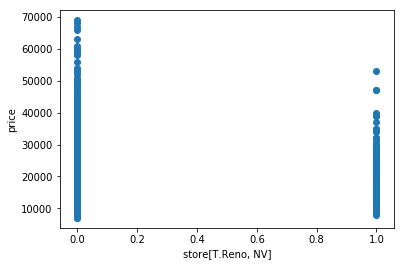

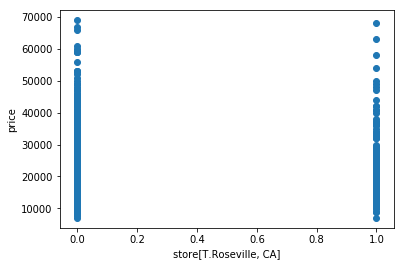

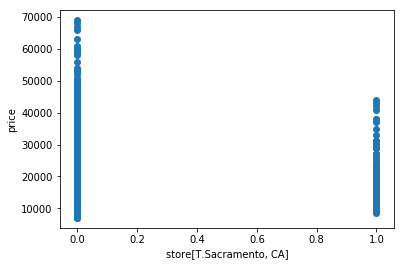

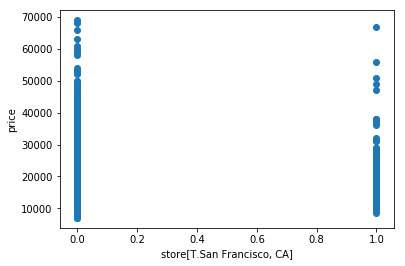

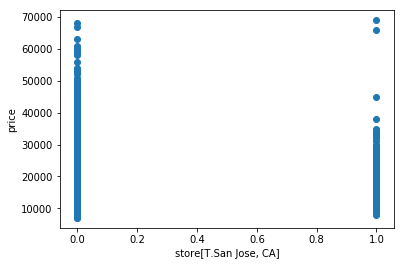

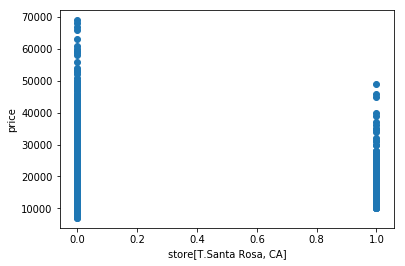

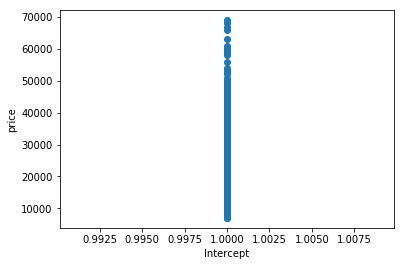

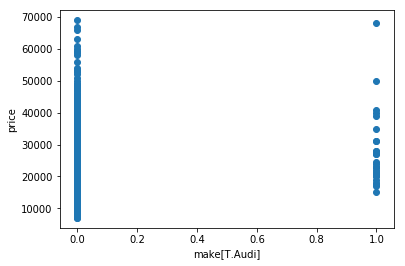

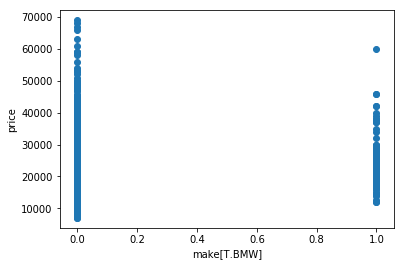

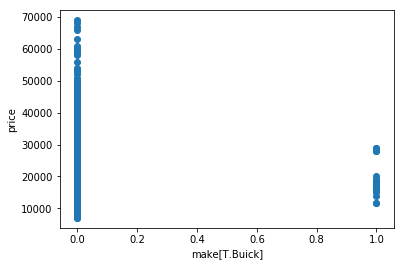

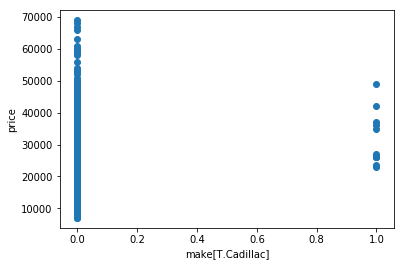

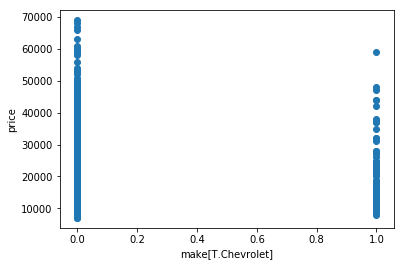

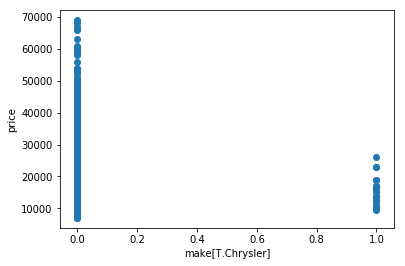

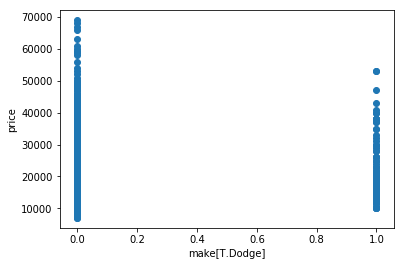

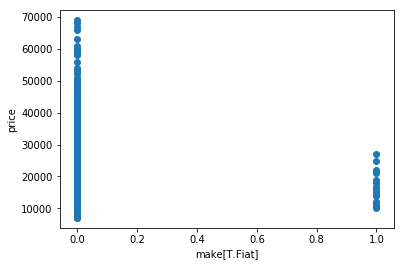

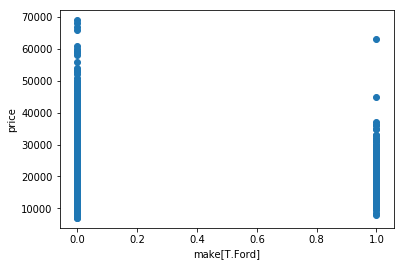

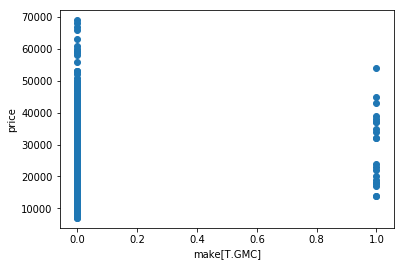

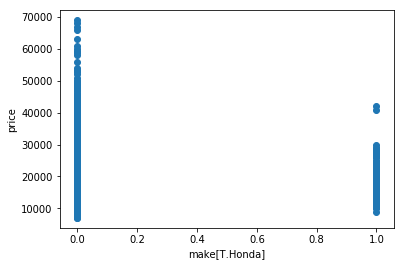

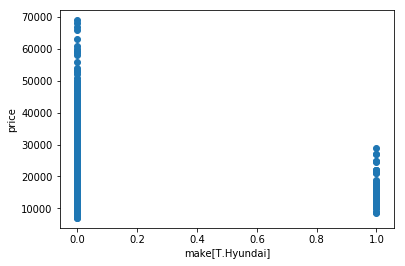

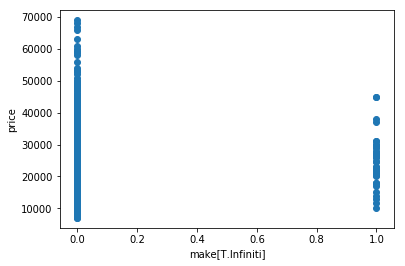

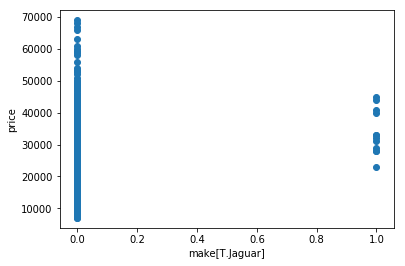

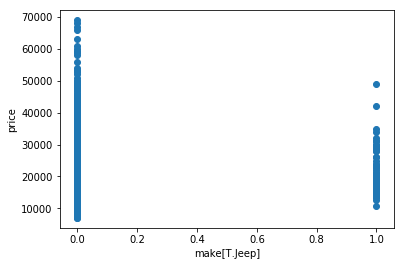

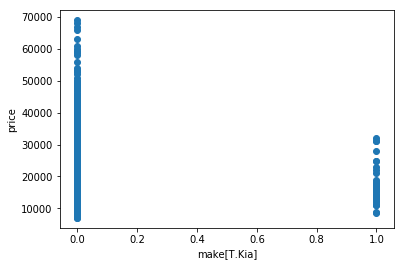

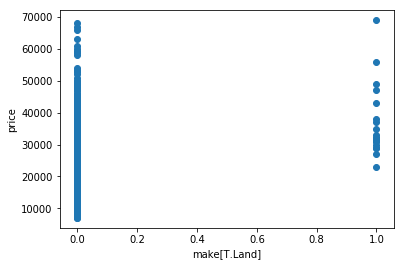

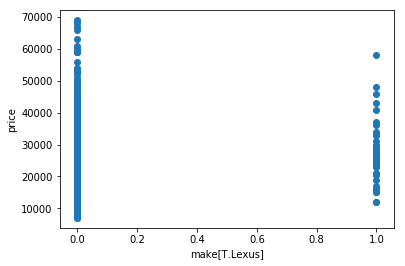

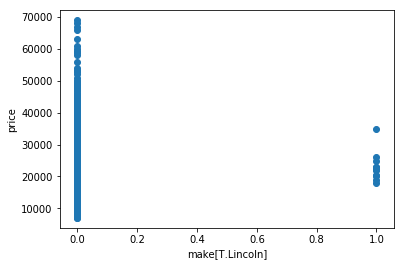

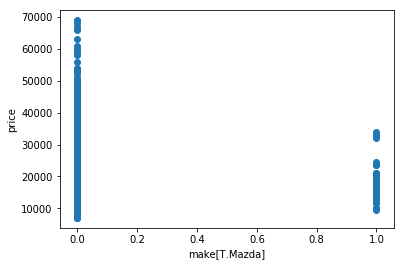

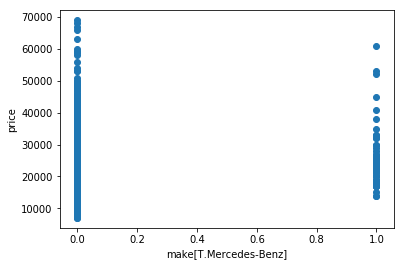

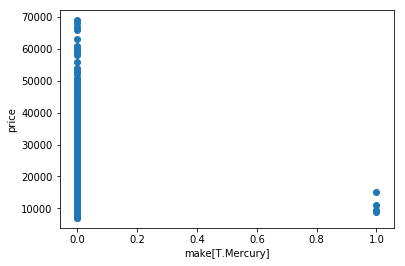

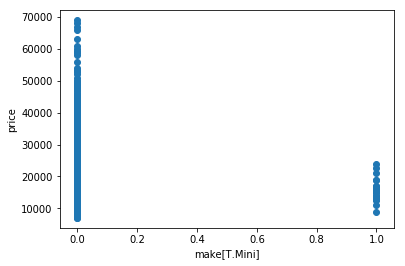

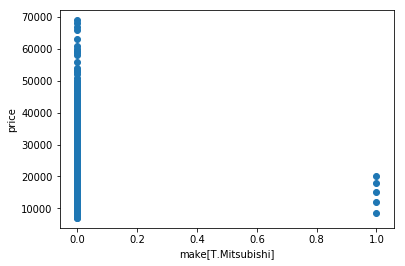

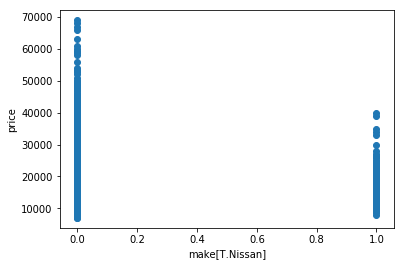

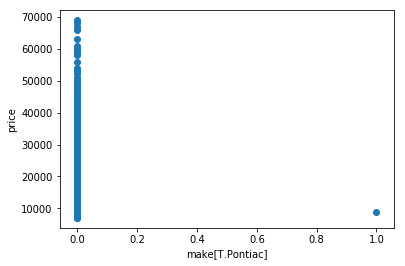

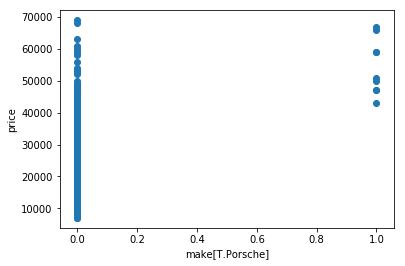

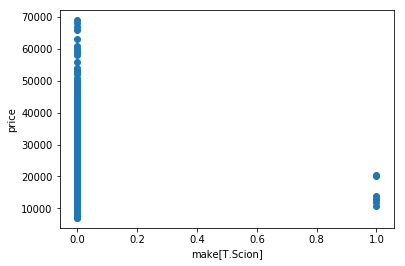

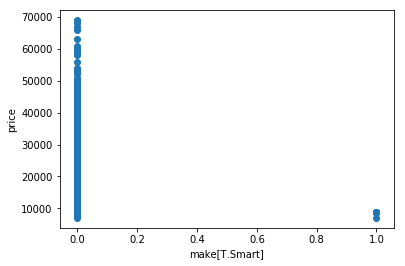

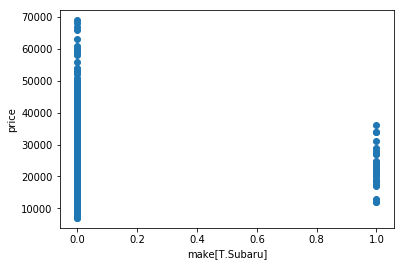

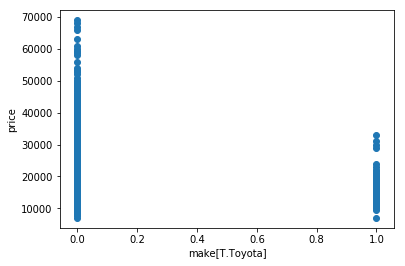

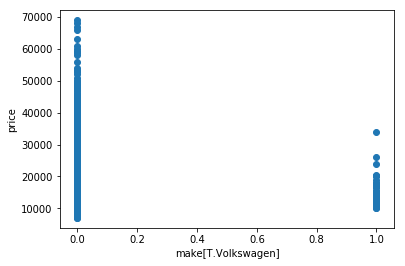

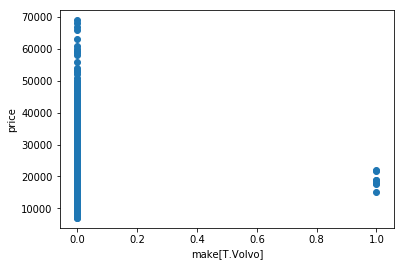

In [322]:
for col in df_num_train:
    plt.figure()
    ax = plt.scatter(x=df_num_train[col], y=y_train)
    plt.xlabel(col)
    plt.ylabel('price')

## Fit data into models

**Model_1 : Basic model with All variables**

In [323]:
model1 = LinearRegression(fit_intercept=False)
model1.fit(X_train_num, y_train)
print ("Training r-squared score: ", model1.score(X_train_num, y_train))
print ("Test r-squared score: ", model1.score(X_test_num, y_test))
print ("Training adj r-squared score: ", get_adj_r2(X_train_num, y_train))
print ("Test adj r-squared score: ", get_adj_r2(X_test_num, y_test))

Training r-squared score:  0.837049651407
Test r-squared score:  0.820792742187
Training adj r-squared score:  0.830426508207
Test adj r-squared score:  0.836564036283


In [324]:
def get_adj_r2(X, y):
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    r2 = model.score(X, y)
    return 1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)

**Model_2: Transform y with log**

In [325]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)
model2 = LinearRegression(fit_intercept=False)
model2.fit(X_train_num, y_train_log)
print ("Training r-squared score: ", model2.score(X_train_num, y_train_log))
print ("Test r-squared score: ", model2.score(X_test_num, y_test_log))
print ("Training adj r-squared score: ", get_adj_r2(X_train_num, y_train_log))
print ("Test adj r-squared score: ", get_adj_r2(X_test_num, y_test_log))

Training r-squared score:  0.872350475773
Test r-squared score:  0.867514217008
Training adj r-squared score:  0.867162140272
Test adj r-squared score:  0.875339085486


In [326]:
model2_sm = sm.OLS(y_train_log, X_train_num).fit()
model2_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     171.0
Date:                Mon, 16 Jul 2018   Prob (F-statistic):               0.00
Time:                        22:32:09   Log-Likelihood:                 900.91
No. Observations:                1614   AIC:                            -1676.
Df Residuals:                    1551   BIC:                            -1336.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
images                         0.0020      0.001      2.995      0.003       0.001       0.003
age                           -0.0526      0.003    -19.028      0.000      -0.058      -0.047
city                           0.0110      0.001      9.492      0.000       0.009       0.013
highway                       -0.0172      0.002    -11.063      0.000      -0.020      -0.014
transmission                  -0.0174      0.017     -1.014      0.311      -0.051       0.016
drive                          0.1326      0.011     11.649      0.000       0.110       0.155
engine                         0.0214      0.012      1.822      0.069      -0.002       0.044
cylinder                       0.0088      0.009      0.976      0.329      -0.009       0.027
horsepower                     0.0012      0.000      8.375      0.000       0.001       0.001
torque                         0.0010      0.000     10.219      0.000       0.001       0.001
rating_5                       0.0004      0.000      0.711      0.477      -0.001       0.001
rating_4                      -0.0001      0.001     -0.085      0.933      -0.003       0.002
rating_3                       0.0012      0.003      0.372      0.710      -0.005       0.008
rating_2                      -0.0095      0.005     -1.869      0.062      -0.019       0.000
rating_1                       0.0041      0.005      0.806      0.420      -0.006       0.014
mileage                       -0.0037      0.000    -17.916      0.000      -0.004      -0.003
owner                      -8.847e-05      0.006     -0.015      0.988      -0.011       0.011
event                          0.0315      0.025      1.284      0.199      -0.017       0.080
recall                         0.0038      0.009      0.405      0.686      -0.015       0.022
store[T.Fremont, CA]           0.0640      0.018      3.476      0.001       0.028       0.100
store[T.Fresno, CA]            0.0366      0.020      1.843      0.066      -0.002       0.076
store[T.Modesto, CA]           0.0335      0.018      1.850      0.064      -0.002       0.069
store[T.Pleasanton, CA]        0.0222      0.017      1.276      0.202      -0.012       0.056
store[T.Reno, NV]              0.0100      0.018      0.554      0.580      -0.026       0.046
store[T.Roseville, CA]         0.0314      0.017      1.825      0.068      -0.002       0.065
store[T.Sacramento, CA]        0.0329      0.019      1.778      0.076      -0.003       0.069
store[T.San Francisco, CA]    -0.0009      0.018     -0.050      0.960      -0.036       0.034
store[T.San Jose, CA]          0.0055      0.018      0.302      0.763      -0.030       0.041
store[T.Santa Rosa, CA]       -0.0024      0.018     -0.136      0.892      -0.037       0.032
Intercept                      9.9320      

Significant predictors are: <br>
    images, age, city, highway, drive, engine, horsepower, torque, mileage

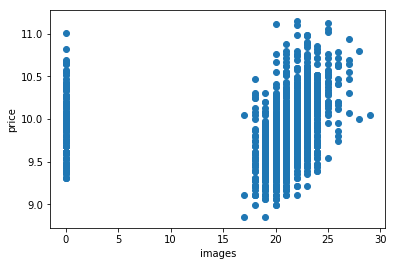

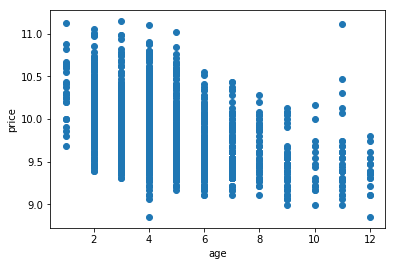

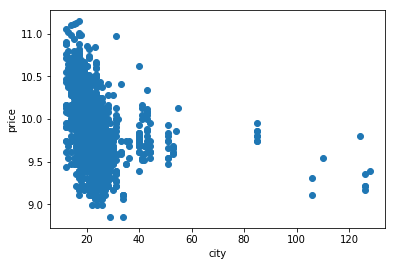

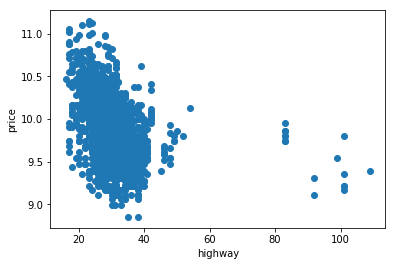

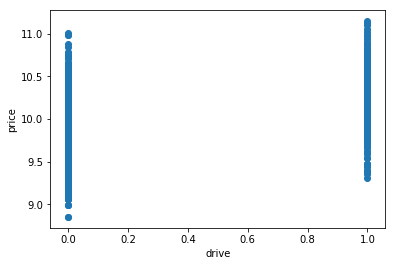

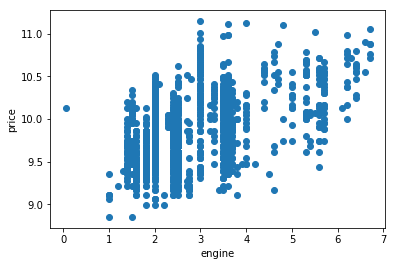

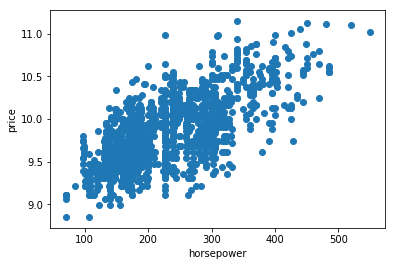

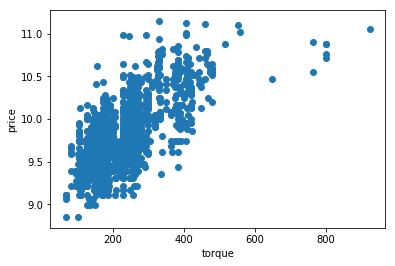

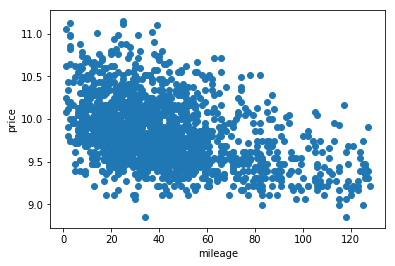

In [327]:
sig_cols = ['images', 'age', 'city', 'highway', 'drive', 'engine', 'horsepower', 'torque', 'mileage']
df_num_train_log = pd.concat((y_train_log, X_train_num), axis=1)
for col in sig_cols:
    plt.figure()
    ax = plt.scatter(x=df_num_train[col], y=y_train_log)
    plt.xlabel(col)
    plt.ylabel('price')

**Model_3: Introduce cross-validation**

In [328]:
reg = LinearRegression(fit_intercept=False)
model1_cv_mse = cross_val_score(reg, X_train_num, y_train, cv=5, scoring='neg_mean_squared_error')
print ("Model 1 MSE Error:", -np.mean(model1_cv_mse))
model2_cv_mse = cross_val_score(reg, X_train_num, y_train_log, cv=5, scoring='neg_mean_squared_error')
print ("Model 2 MSE Error:", -np.mean(model2_cv_mse))


Model 1 MSE Error: 14007277.7107
Model 2 MSE Error: 0.0211792574281


** Model_4: Introduce polynomial terms **

In [391]:
X_train_poly = deepcopy(X_train_num)
X_train_poly['torque_log'] = np.log(X_train_poly['torque'])
X_train_poly['horsepower_log'] = np.log(X_train_poly['horsepower'])
X_train_poly['image_quad'] = X_train_poly['images']**2
X_train_poly['image_cub'] = X_train_poly['images']**3
X_train_poly['age_quad'] = X_train_poly['age']**2
X_train_poly['age_cub'] = X_train_poly['age']**3

In [393]:
X_test_poly = deepcopy(X_test_num)
X_test_poly['torque_log'] = np.log(X_test_poly['torque'])
X_test_poly['horsepower_log'] = np.log(X_test_poly['horsepower'])
X_test_poly['image_quad'] = X_test_poly['images']**2
X_test_poly['image_cub'] = X_test_poly['images']**3
X_test_poly['age_quad'] = X_test_poly['age']**2
X_test_poly['age_cub'] = X_test_poly['age']**3

In [394]:
model4 = LinearRegression(fit_intercept=False)
model4.fit(X_train_poly, y_train_log)
print ("Training r-squared score: ", model4.score(X_train_poly, y_train_log))
print ("Test r-squared score: ", model4.score(X_test_poly, y_test_log))
print ("Training adj r-squared score: ", get_adj_r2(X_train_poly, y_train_log))
print ("Test adj r-squared score: ", get_adj_r2(X_test_poly, y_test_log))

Training r-squared score:  0.887437191073
Test r-squared score:  0.886262908456
Training adj r-squared score:  0.882406858291
Test adj r-squared score:  0.891390675835


In [395]:
# Create your model
model4_sm = sm.OLS(y_train_log, X_train_poly).fit()

# Print summary statistics of the model's performance
model4_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     179.1
Date:                Mon, 16 Jul 2018   Prob (F-statistic):               0.00
Time:                        22:45:23   Log-Likelihood:                 1002.4
No. Observations:                1614   AIC:                            -1867.
Df Residuals:                    1545   BIC:                            -1495.
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
images                        -0.0533      0.017     -3.048      0.002      -0.088      -0.019
age                           -0.0682      0.018     -3.732      0.000      -0.104      -0.032
city                           0.0096      0.001      8.663      0.000       0.007       0.012
highway                       -0.0149      0.002     -9.896      0.000      -0.018      -0.012
transmission                   0.0037      0.016      0.228      0.820      -0.028       0.036
drive                          0.1211      0.011     11.244      0.000       0.100       0.142
engine                         0.0159      0.011      1.417      0.157      -0.006       0.038
cylinder                       0.0125      0.009      1.408      0.159      -0.005       0.030
horsepower                     0.0001      0.000      0.373      0.709      -0.001       0.001
torque                         0.0011      0.000      5.361      0.000       0.001       0.001
rating_5                       0.0005      0.000      0.966      0.334      -0.000       0.001
rating_4                      -0.0002      0.001     -0.200      0.841      -0.003       0.002
rating_3                       0.0008      0.003      0.244      0.807      -0.005       0.007
rating_2                      -0.0093      0.005     -1.928      0.054      -0.019       0.000
rating_1                       0.0045      0.005      0.933      0.351      -0.005       0.014
mileage                       -0.0038      0.000    -19.318      0.000      -0.004      -0.003
owner                          0.0060      0.006      1.095      0.274      -0.005       0.017
event                          0.0120      0.023      0.516      0.606      -0.034       0.057
recall                        -0.0008      0.009     -0.088      0.930      -0.018       0.017
store[T.Fremont, CA]           0.0440      0.017      2.529      0.012       0.010       0.078
store[T.Fresno, CA]            0.0629      0.019      3.332      0.001       0.026       0.100
store[T.Modesto, CA]           0.0207      0.017      1.213      0.225      -0.013       0.054
store[T.Pleasanton, CA]        0.0232      0.016      1.414      0.158      -0.009       0.055
store[T.Reno, NV]              0.0024      0.017      0.138      0.891      -0.031       0.036
store[T.Roseville, CA]     -1.442e-05      0.016     -0.001      0.999      -0.032       0.032
store[T.Sacramento, CA]        0.0479      0.018      2.734      0.006       0.014       0.082
store[T.San Francisco, CA]     0.0055      0.017      0.331      0.741      -0.027       0.038
store[T.San Jose, CA]          0.0050      0.017      0.292      0.770      -0.029       0.039
store[T.Santa Rosa, CA]        0.0109      0.017      0.653      0.514      -0.022       0.044
Intercept                      9.1314      

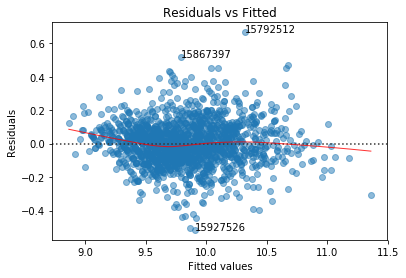

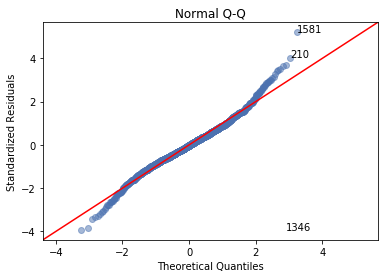

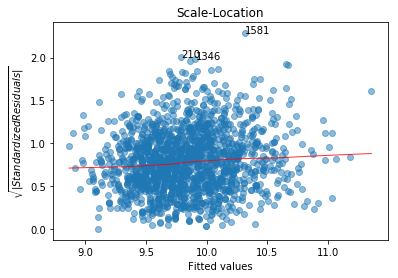

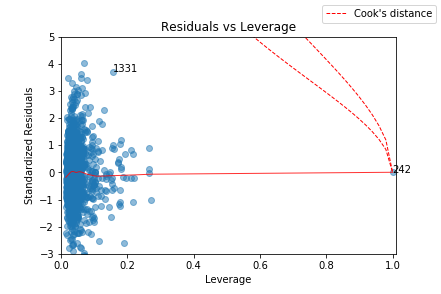

In [396]:
diagnostic_plots.diagnostic_plots(X_train_poly, y_train_log, model4_sm)

Model_5: Different transformations

In [334]:
X_train_poly2 = deepcopy(X_train_num)
X_train_poly2['torque_quad'] = X_train_poly2['torque']**2
X_train_poly2['torque_cub'] = X_train_poly2['torque']**3
X_train_poly2['horsepower_log'] = np.log(X_train_poly2['horsepower'])
X_train_poly2['mileage_quad'] = X_train_poly2['mileage']**2
X_train_poly2['mileage_cub'] = X_train_poly2['mileage']**3

In [335]:
# Create your model
model5_sm = sm.OLS(y_train_log, X_train_poly2).fit()

# Print summary statistics of the model's performance
model5_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     163.9
Date:                Mon, 16 Jul 2018   Prob (F-statistic):               0.00
Time:                        22:32:15   Log-Likelihood:                 928.22
No. Observations:                1614   AIC:                            -1720.
Df Residuals:                    1546   BIC:                            -1354.
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
images                         0.0019      0.001      2.796      0.005       0.001       0.003
age                           -0.0513      0.003    -18.701      0.000      -0.057      -0.046
city                           0.0111      0.001      9.717      0.000       0.009       0.013
highway                       -0.0169      0.002    -10.931      0.000      -0.020      -0.014
transmission                  -0.0172      0.017     -0.998      0.319      -0.051       0.017
drive                          0.1284      0.011     11.438      0.000       0.106       0.150
engine                         0.0203      0.012      1.703      0.089      -0.003       0.044
cylinder                       0.0111      0.009      1.180      0.238      -0.007       0.029
horsepower                    -0.0009      0.000     -1.971      0.049      -0.002   -4.04e-06
torque                        -0.0007      0.001     -1.117      0.264      -0.002       0.001
rating_5                       0.0002      0.000      0.393      0.694      -0.001       0.001
rating_4                   -4.021e-05      0.001     -0.031      0.975      -0.003       0.003
rating_3                       0.0011      0.003      0.340      0.734      -0.005       0.007
rating_2                      -0.0105      0.005     -2.085      0.037      -0.020      -0.001
rating_1                       0.0049      0.005      0.963      0.336      -0.005       0.015
mileage                       -0.0089      0.001     -7.686      0.000      -0.011      -0.007
owner                         -0.0013      0.006     -0.233      0.816      -0.013       0.010
event                          0.0180      0.024      0.741      0.459      -0.030       0.066
recall                         0.0013      0.009      0.141      0.888      -0.017       0.020
store[T.Fremont, CA]           0.0655      0.018      3.612      0.000       0.030       0.101
store[T.Fresno, CA]            0.0383      0.020      1.956      0.051   -9.84e-05       0.077
store[T.Modesto, CA]           0.0309      0.018      1.729      0.084      -0.004       0.066
store[T.Pleasanton, CA]        0.0223      0.017      1.299      0.194      -0.011       0.056
store[T.Reno, NV]              0.0114      0.018      0.637      0.524      -0.024       0.046
store[T.Roseville, CA]         0.0293      0.017      1.727      0.084      -0.004       0.063
store[T.Sacramento, CA]        0.0312      0.018      1.708      0.088      -0.005       0.067
store[T.San Francisco, CA]     0.0027      0.017      0.156      0.876      -0.031       0.037
store[T.San Jose, CA]          0.0091      0.018      0.506      0.613      -0.026       0.044
store[T.Santa Rosa, CA]        0.0015      0.017      0.086      0.932      -0.033       0.036
Intercept                      8.3510      

In [336]:
X_test_poly2 = deepcopy(X_test_num)
X_test_poly2['torque_quad'] = X_test_poly2['torque']**2
X_test_poly2['torque_cub'] = X_test_poly2['torque']**3
X_test_poly2['horsepower_log'] = np.log(X_test_poly2['horsepower'])
X_test_poly2['mileage_quad'] = X_test_poly2['mileage']**2
X_test_poly2['mileage_cub'] = X_test_poly2['mileage']**3

In [337]:
model5 = LinearRegression(fit_intercept=False)
model5.fit(X_train_poly2, y_train_log)
print ("Training r-squared score: ", model5.score(X_train_poly2, y_train_log))
print ("Test r-squared score: ", model5.score(X_test_poly2, y_test_log))
print ("Training adj r-squared score: ", get_adj_r2(X_train_poly2, y_train_log))
print ("Test adj r-squared score: ", get_adj_r2(X_test_poly2, y_test_log))

Training r-squared score:  0.876597245881
Test r-squared score:  0.87233078565
Training adj r-squared score:  0.871165927253
Test adj r-squared score:  0.88089814856


** Model_6: Incorporate Lasso regularization **

In [399]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [400]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train_poly_norm = min_max_scaler.fit_transform(X_train_poly)

In [340]:
model6_lasso =  Lasso(alpha = 0.00001)
model6_lasso.fit(X_train_poly_norm, y_train_log)
model6_lasso.score(X_train_poly_norm, y_train_log)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.88723280431275586

In [341]:
alphas = [10**x for x in range(-12, 5)]
lscore = np.zeros((len(alphas), 1))
lcv_list = []
for i in range(len(alphas)):
    lcv = LassoCV(alphas=[alphas[i]], cv=5, normalize=False)
    lcv.fit(X_train_poly_norm, y_train_log)
    lcv_list.append(lcv)
    lscore[i] = lcv.score(X_train_poly_norm, y_train_log)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coo

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coo

In [342]:
print ("Best lambda is {}".format(alphas[lscore.argmax()]))
print ("Best r2 score is {}".format(lscore.max()))

Best lambda is 1e-12
Best r2 score is 0.8873148555339946


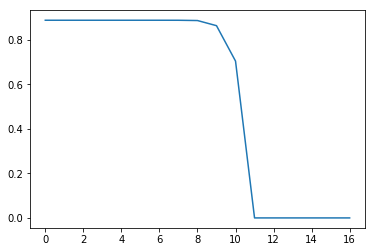

In [343]:
plt.plot(range(len(lscore)), lscore)

In [344]:
X_test_poly_norm = min_max_scaler.transform(X_test_poly)

In [345]:
alpha = 1e-12
model6_lasso =  Lasso(alpha = alpha)
model6_lasso.fit(X_test_poly_norm, y_test_log)
model6_lasso.score(X_test_poly_norm, y_test_log)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.90519117544536043

### Add label for luxury cars

In [402]:
luxury = np.zeros((X_train.shape[0], 1))

In [248]:
luxury+luxury

array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [403]:
col_map = {}
luxury_cars = (['Lincoln', 'Dodge', 'BMW', 'Infiniti', 'Mercedes-Benz', 'Lexus', 'Audi' ,'GMC', 'Cadillac', 'Jaguar', 
               'Land', 'Porsche'])
luxury = np.zeros((X_train_poly.shape[0], 1))
for col in X_train_poly.columns:
    make = col.replace("make[T.","").replace("]","")
    if make in luxury_cars:
        luxury = luxury + (np.array(X_train_poly[col])).reshape(-1,1)

In [456]:
cadillac = np.zeros((X_train_poly.shape[0], 1))
for col in X_train_poly.columns:
    if ('make' in col):
        cadillac = cadillac + (np.array(X_train_poly[col])).reshape(-1,1)
cadillac = 1- cadillac

In [457]:
X_train_luxury = X_train_poly
X_train_luxury['luxury'] = luxury + cadillac

In [458]:
X_train_luxury['mileage_morethan_100k'] = X_train_luxury['mileage'].apply(lambda x:1 if x > 100 else 0)

In [471]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train_luxury_norm = min_max_scaler.fit_transform(X_train_luxury)
model7_lasso =  LassoCV(alphas = [1e-12], cv=5)
model7_lasso.fit(X_train_luxury_norm, y_train_log)
model7_lasso.score(X_train_luxury_norm, y_train_log)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coo

0.88732650502036159

In [472]:
model7_sm = sm.OLS(y_train_log, X_train_luxury).fit()

# Print summary statistics of the model's performance
model7_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     176.4
Date:                Mon, 16 Jul 2018   Prob (F-statistic):               0.00
Time:                        23:17:57   Log-Likelihood:                 1002.5
No. Observations:                1614   AIC:                            -1865.
Df Residuals:                    1544   BIC:                            -1488.
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
images                        -0.0535      0.017     -3.060      0.002      -0.088      -0.019
age                           -0.0689      0.018     -3.756      0.000      -0.105      -0.033
city                           0.0096      0.001      8.645      0.000       0.007       0.012
highway                       -0.0149      0.002     -9.869      0.000      -0.018      -0.012
transmission                   0.0041      0.016      0.248      0.804      -0.028       0.036
drive                          0.1211      0.011     11.237      0.000       0.100       0.142
engine                         0.0159      0.011      1.417      0.157      -0.006       0.038
cylinder                       0.0124      0.009      1.401      0.161      -0.005       0.030
horsepower                     0.0001      0.000      0.370      0.711      -0.001       0.001
torque                         0.0011      0.000      5.363      0.000       0.001       0.001
rating_5                       0.0004      0.000      0.936      0.350      -0.000       0.001
rating_4                      -0.0002      0.001     -0.180      0.857      -0.003       0.002
rating_3                       0.0007      0.003      0.232      0.816      -0.005       0.007
rating_2                      -0.0093      0.005     -1.941      0.052      -0.019    9.91e-05
rating_1                       0.0046      0.005      0.948      0.343      -0.005       0.014
mileage                       -0.0037      0.000    -16.788      0.000      -0.004      -0.003
owner                          0.0060      0.006      1.088      0.277      -0.005       0.017
event                          0.0121      0.023      0.523      0.601      -0.033       0.058
recall                        -0.0010      0.009     -0.112      0.911      -0.018       0.016
store[T.Fremont, CA]           0.0439      0.017      2.521      0.012       0.010       0.078
store[T.Fresno, CA]            0.0630      0.019      3.332      0.001       0.026       0.100
store[T.Modesto, CA]           0.0205      0.017      1.197      0.232      -0.013       0.054
store[T.Pleasanton, CA]        0.0230      0.016      1.400      0.162      -0.009       0.055
store[T.Reno, NV]              0.0021      0.017      0.123      0.902      -0.031       0.036
store[T.Roseville, CA]        -0.0004      0.016     -0.027      0.979      -0.033       0.032
store[T.Sacramento, CA]        0.0481      0.018      2.744      0.006       0.014       0.083
store[T.San Francisco, CA]     0.0055      0.017      0.327      0.744      -0.027       0.038
store[T.San Jose, CA]          0.0048      0.017      0.277      0.782      -0.029       0.039
store[T.Santa Rosa, CA]        0.0107      0.017      0.645      0.519      -0.022       0.043
Intercept                      8.6192      

In [478]:
alphas = [10**x for x in range(-12, 5)]
lscore = np.zeros((len(alphas), 1))
lcv_list = []
for i in range(len(alphas)):
    lcv = LassoCV(alphas=[alphas[i]], cv=5, normalize=False)
    lcv.fit(X_train_luxury_norm, y_train_log)
    lcv_list.append(lcv)
    lscore[i] = lcv.score(X_train_luxury_norm, y_train_log)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coo

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coo

In [479]:
print ("Best lambda is {}".format(alphas[lscore.argmax()]))
print ("Best r2 score is {}".format(lscore.max()))

Best lambda is 1e-12
Best r2 score is 0.8873265050203616


/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/statsmodels/stats/outliers_influence.py:323: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/songlin/Metis/metiswork/project/project2_luther/diagnostic_plots.py:131: RuntimeWarning: invalid value encountered in sqrt
  graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
/Users/

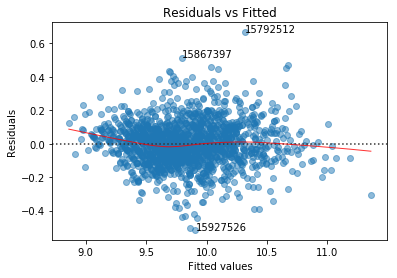

ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

In [473]:
diagnostic_plots.diagnostic_plots(X_train_luxury, y_train_log, model7_sm)

In [475]:
X_train_luxury.describe()

,images,age,city,highway,transmission,drive,engine,cylinder,horsepower,torque,...,make[T.Volkswagen],make[T.Volvo],torque_log,horsepower_log,image_quad,image_cub,age_quad,age_cub,luxury,mileage_morethan_100k
count,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,...,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000
mean,19.693928,4.643742,23.676431,31.466045,0.048327,0.197646,2.748498,4.923947,227.042133,228.353175,...,0.052664,0.004337,5.363556,5.367607,422.457249,9125.846344,26.426890,180.420694,0.299876,0.043371
std,5.884547,2.205802,10.384211,8.489948,0.214523,0.398347,1.095447,1.295660,77.806631,89.795191,...,0.223431,0.065734,0.363333,0.341342,141.730761,3575.880628,27.070788,298.641445,0.458345,0.203753
min,0.000000,1.000000,12.000000,16.000000,0.000000,0.000000,0.060000,2.000000,70.000000,68.000000,...,0.000000,0.000000,4.219508,4.248495,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,3.000000,19.000000,27.000000,0.000000,0.000000,2.000000,4.000000,172.000000,172.000000,...,0.000000,0.000000,5.147494,5.147494,400.000000,8000.000000,9.000000,27.000000,0.000000,0.000000
50%,21.000000,4.000000,23.000000,31.466045,0.000000,0.000000,2.400000,4.000000,208.000000,228.353175,...,0.000000,0.000000,5.430893,5.337538,441.000000,9261.000000,16.000000,64.000000,0.000000,0.000000
75%,22.000000,6.000000,25.000000,35.000000,0.000000,0.000000,3.500000,6.000000,285.000000,264.000000,...,0.000000,0.000000,5.575949,5.652489,484.000000,10648.000000,36.000000,216.000000,1.000000,0.000000
max,29.000000,12.000000,128.000000,109.000000,1.000000,1.000000,6.700000,8.000000,550.000000,925.000000,...,1.000000,1.000000,6.829794,6.309918,841.000000,24389.000000,144.000000,1728.000000,1.000000,1.000000


In [466]:
idx = 242
model7_sm.predict(X_train_luxury)[idx-1], y_train_log[idx-1]

(9.5209652609380999, 9.5177515396089589)

In [467]:
X_train_luxury.iloc[i,:]

images                           20.000000
age                               5.000000
city                             23.676431
highway                          31.466045
transmission                      0.000000
drive                             0.000000
engine                            2.400000
cylinder                          4.000000
horsepower                      182.000000
torque                          172.000000
rating_5                         30.000000
rating_4                         18.000000
rating_3                          3.000000
rating_2                          2.000000
rating_1                          1.000000
mileage                          66.000000
owner                             3.000000
event                             0.000000
recall                            0.000000
store[T.Fremont, CA]              0.000000
store[T.Fresno, CA]               0.000000
store[T.Modesto, CA]              1.000000
store[T.Pleasanton, CA]           0.000000
store[T.Ren

In [420]:
print ("predicted:", np.exp(model7_sm.predict(X_train_luxury)[idx-1]))

predicted: 15478.8308071


In [421]:
print ("actual:", np.exp(y_train_log[idx-1]), y_train[idx-1])

actual: 13599.0 13599.0


In [418]:
X_train_luxury.head()

,images,age,city,highway,transmission,drive,engine,cylinder,horsepower,torque,...,make[T.Volkswagen],make[T.Volvo],torque_log,horsepower_log,image_quad,image_cub,age_quad,age_cub,luxury,mileage_morethan_100k
stock_id,,,,,,,,,,,,,,,,,,,,,
16057160,20,5,24.000000,34.000000,0,0,1.8,4.0,170.0,184.0,...,1.0,0.0,5.214936,5.135798,400,8000,25,125,0.0,0
16057266,20,4,26.000000,34.000000,0,0,1.4,4.0,138.0,148.0,...,0.0,0.0,4.997212,4.927254,400,8000,16,64,0.0,0
15867037,21,2,25.000000,32.000000,0,0,2.0,4.0,189.0,207.0,...,0.0,0.0,5.332719,5.241747,441,9261,4,8,0.0,0
16211748,0,2,17.000000,24.000000,0,0,3.0,6.0,425.0,406.0,...,0.0,0.0,6.006353,6.052089,0,0,4,8,1.0,0
16062084,20,5,23.676431,31.466045,0,0,2.4,4.0,173.0,166.0,...,0.0,0.0,5.111988,5.153292,400,8000,25,125,1.0,0


In [419]:
y_train.head()

stock_id
16057160    11998.0
16057266    14998.0
15867037    22599.0
16211748    59998.0
16062084    12599.0
Name: price, dtype: float64

In [422]:
X_train_luxury.index[idx-1]

'15998148'

In [353]:
X_train_luxury.iloc[idx-1,:], y_train[idx-1]

(images                           24.000000
 age                               7.000000
 city                             12.000000
 highway                          18.000000
 transmission                      0.000000
 drive                             1.000000
 engine                            6.200000
 cylinder                          8.000000
 horsepower                      403.000000
 torque                          417.000000
 rating_5                         10.000000
 rating_4                          3.000000
 rating_3                          1.000000
 rating_2                          0.000000
 rating_1                          0.000000
 mileage                          43.000000
 owner                             1.000000
 event                             0.000000
 recall                            0.000000
 store[T.Fremont, CA]              0.000000
 store[T.Fresno, CA]               0.000000
 store[T.Modesto, CA]              0.000000
 store[T.Pleasanton, CA]        

In [429]:
predicted = model7_sm.predict(X_train_luxury)
X_train_luxury['predicted'] = np.exp(predicted)

In [430]:
X_train_luxury['price'] = y_train

In [431]:
X_train_luxury['pred_perc'] = X_train_luxury['predicted']/X_train_luxury['price']

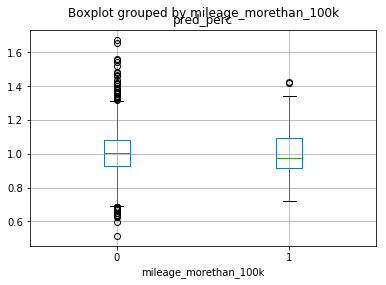

In [434]:
X_train_luxury.boxplot(column='pred_perc', by='mileage_morethan_100k')

In [439]:
over_estimated = X_train_luxury[X_train_luxury['pred_perc']>1.2]
over_estimated.to_csv('over_estimated.csv')

In [436]:
model7_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     176.4
Date:                Mon, 16 Jul 2018   Prob (F-statistic):               0.00
Time:                        22:56:32   Log-Likelihood:                 1002.5
No. Observations:                1614   AIC:                            -1865.
Df Residuals:                    1544   BIC:                            -1488.
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
images                        -0.0535      0.017     -3.060      0.002      -0.088      -0.019
age                           -0.0689      0.018     -3.756      0.000      -0.105      -0.033
city                           0.0096      0.001      8.645      0.000       0.007       0.012
highway                       -0.0149      0.002     -9.869      0.000      -0.018      -0.012
transmission                   0.0041      0.016      0.248      0.804      -0.028       0.036
drive                          0.1211      0.011     11.237      0.000       0.100       0.142
engine                         0.0159      0.011      1.417      0.157      -0.006       0.038
cylinder                       0.0124      0.009      1.401      0.161      -0.005       0.030
horsepower                     0.0001      0.000      0.370      0.711      -0.001       0.001
torque                         0.0011      0.000      5.363      0.000       0.001       0.001
rating_5                       0.0004      0.000      0.936      0.350      -0.000       0.001
rating_4                      -0.0002      0.001     -0.180      0.857      -0.003       0.002
rating_3                       0.0007      0.003      0.232      0.816      -0.005       0.007
rating_2                      -0.0093      0.005     -1.941      0.052      -0.019    9.91e-05
rating_1                       0.0046      0.005      0.948      0.343      -0.005       0.014
mileage                       -0.0037      0.000    -16.788      0.000      -0.004      -0.003
owner                          0.0060      0.006      1.088      0.277      -0.005       0.017
event                          0.0121      0.023      0.523      0.601      -0.033       0.058
recall                        -0.0010      0.009     -0.112      0.911      -0.018       0.016
store[T.Fremont, CA]           0.0439      0.017      2.521      0.012       0.010       0.078
store[T.Fresno, CA]            0.0630      0.019      3.332      0.001       0.026       0.100
store[T.Modesto, CA]           0.0205      0.017      1.197      0.232      -0.013       0.054
store[T.Pleasanton, CA]        0.0230      0.016      1.400      0.162      -0.009       0.055
store[T.Reno, NV]              0.0021      0.017      0.123      0.902      -0.031       0.036
store[T.Roseville, CA]        -0.0004      0.016     -0.027      0.979      -0.033       0.032
store[T.Sacramento, CA]        0.0481      0.018      2.744      0.006       0.014       0.083
store[T.San Francisco, CA]     0.0055      0.017      0.327      0.744      -0.027       0.038
store[T.San Jose, CA]          0.0048      0.017      0.277      0.782      -0.029       0.039
store[T.Santa Rosa, CA]        0.0107      0.017      0.645      0.519      -0.022       0.043
Intercept                      9.1292      

In [470]:
X_train_luxury.drop(['predicted', 'price', 'pred_perc'], axis=1, inplace=True)

###

Criteria to remove predictors? <br>
- look at high p-values -> backward selection
- Lasso/Ridge
- Categorize the categorical data

How to deal with outliers? Especially <br>
- Analyze the outliers and introduce more features to describe them
- For high leverage points, introduce transformation to make the data less leveraged

How to compare two models with different y? <br>
- If y is transformed, all scores including r squared are not on the same scale
- use exp to return y to original scale

How to include higher polynomial terms efficiently? <>
- Use PolynomialFeatures?


## Learning curve

In [156]:
from sklearn.model_selection import learning_curve
# Make a model, say quadratic

learning_curve(model6_lasso, X_test_poly_norm, y_test_log, cv=5)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coo

(array([ 43, 140, 237, 334, 431]),
 array([[ 0.99993077,  0.99999272,  0.99999272,  0.99999272,  0.99999272],
        [ 0.93869002,  0.94951758,  0.93848881,  0.93848881,  0.93848881],
        [ 0.92916762,  0.94050674,  0.92125214,  0.91855686,  0.91855686],
        [ 0.91354844,  0.92188808,  0.91110487,  0.91597975,  0.91706832],
        [ 0.91092852,  0.91970182,  0.91169569,  0.91424945,  0.91151026]]),
 array([[-2.21551897,  0.32545625,  0.45280666,  0.50669131,  0.4808162 ],
        [ 0.65019951,  0.74423607,  0.8376107 ,  0.83098907,  0.79761737],
        [ 0.82716988,  0.78364563,  0.88606134,  0.86776302,  0.86607144],
        [ 0.87404463,  0.81411847,  0.88571943,  0.87560795,  0.86970839],
        [ 0.89082083,  0.82584521,  0.88287712,  0.8775152 ,  0.87612783]]))

In [157]:
train_sizes, train_scores, test_scores = learning_curve(model6_lasso, X_test_poly_norm, y_test_log, cv=5)


/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/linear_model/coo

In [161]:
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df  = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})


(-1, 1)

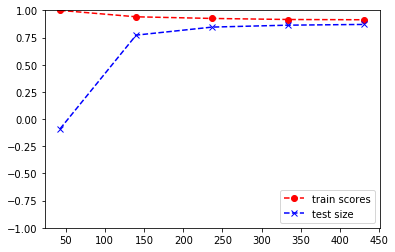

In [162]:
plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test size')
plt.legend(loc='lower right')
plt.ylim(-1,1)

In [163]:
train_scores

array([[ 0.99993077,  0.99999272,  0.99999272,  0.99999272,  0.99999272],
       [ 0.93869002,  0.94951758,  0.93848881,  0.93848881,  0.93848881],
       [ 0.92916762,  0.94050674,  0.92125214,  0.91855686,  0.91855686],
       [ 0.91354844,  0.92188808,  0.91110487,  0.91597975,  0.91706832],
       [ 0.91092852,  0.91970182,  0.91169569,  0.91424945,  0.91151026]])

### Perform clustering task for 